### TMA4320 - Project 2: Physics


# 0.0 Motivation

In [25]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

# To show figures in the notebook
%matplotlib inline

# Make the figures more readable
newparams = {'figure.figsize': (18, 9), 'axes.grid': False,
             'lines.linewidth': 2,
             'font.size': 25, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}
# figure.figsize sets the size of the figure (values are in inches)
# axes.grid, set to False means that there is no grid
# lines.linewidth sets the thickness of the lines in the plot
# font.size sets the size of the text (ticks, title, xlabel, etc.)
# mathtext.fontset sets the font of the text of the type r'$tekst$' (math text)
# font.family sets the font of ordinary text (ticks, title, xlabel, etc.)

# There are several other parameters you can change, and you can look them up in the documentation 
# for matplotlib if you need to change any. 

plt.rcParams.update(newparams) # Updates the parameter set above. 

In [26]:
# Parameters
sigma_0 = 1000 # kg/m^2
sigma = 500 # kg/m^2
R = 10 # m, Radius
A_s = 0.5*np.pi*(R**2) # Cross-section of boat
g = 9.81 # m/s^2
h = (4*R)/(3*np.pi)

A_0 = (sigma*np.pi*(R**2))/(2*sigma_0)

In [27]:
def calculate_I_c(m, R):
    return 0.5*m*(R**2)*(1-(32/(9*(np.pi**2))))

m = A_s*sigma
I_c = calculate_I_c(m, R)

In [28]:
def newton(f, df, x0, tol=1.e-8, max_iter=30):
    ''' Solve f(x)=0 by Newtons method, shamelessly copied from the note
    "Numerical Solution of Nonlinear Equations" by Anne Kværnø
        The output of each iteration is printed
        Input:
        f, df:   The function f and its derivate f'.
        x0:  Initial values
        tol: The tolerance
      Output:
        The root and the number of iterations
    '''
    x = x0
    print(f"k ={0:3d}, x = {x:18.15f}, f(x) = {f(x):10.3e}")
    for k in range(max_iter):
        fx = f(x)
        if abs(fx) < tol:           # Accept the solution 
            break 
        x = x - fx/df(x)            # Newton-iteration
        print(f"k ={k+1:3d}, x = {x:18.15f}, f(x) = {f(x):10.3e}")
    return x, k+1

In [29]:
def excercise_1a():
    f = lambda beta: beta - np.sin(beta) -np.pi * sigma/sigma_0
    df = lambda beta: 1 - np.cos(beta)
    beta, iters = newton(f,df,5)
    print("Beta = ",round(np.degrees(beta), 2),"degrees")

excercise_1a()

beta = 132.3464590340394
beta = np.radians(beta)


#Define the global variables for the equilibrium, as requested in 1b)
y_M_0 = R*np.cos(beta/2)
y_C_0 = y_M_0 - 4*R/(3*np.pi)
y_B_0 = y_M_0 - 4*R*(np.sin(beta/2))**3 /(3*(beta-np.sin(beta)))
y_D_0 = y_M_0 - R

#Values as functions of delta y_C and theta. 
y_M = lambda theta, delta_y_C : y_M_0 + ((4*R)/(3*np.pi))*(np.cos(theta)-1) + delta_y_C
y_C = lambda delta_y_c : y_C_0 + delta_y_c
y_D = lambda theta, delta_y_c : y_D_0 + ((4*R)/(3*np.pi))*(np.cos(theta)-1) + delta_y_c
y_B = y_B_0

#Note: beta is a global variable
gamma = lambda theta, delta_y_c : 2*np.arccos(np.cos(beta/2)-(4/(3*np.pi))*(1-np.cos(theta))+delta_y_c/R)

water_area = lambda gamma: 0.5*(R**2)*(gamma - np.sin(gamma))

F_G = lambda m : -m*g
F_B = lambda A : A*sigma_0*g
friction = lambda k_f,omega,gamma : -k_f * R * gamma*omega

k =  0, x =  5.000000000000000, f(x) =  4.388e+00
k =  1, x = -1.125780126106932, f(x) = -1.794e+00
k =  2, x =  2.024151652930856, f(x) = -4.456e-01
k =  3, x =  2.334048802844800, f(x) =  4.066e-02
k =  4, x =  2.310007184357851, f(x) =  2.104e-04
k =  5, x =  2.309881463499782, f(x) =  5.840e-09
Beta =  132.35 degrees



# 1.3 Euler metoden


In [30]:
def euler_step(f, t, w, h_step):
    '''
    Tar inn en vektor-funksjon på formen w = [theta(t), omega(t)], med nåværende tid (t) og 
    tilstand (w), og regner ut ett Euler-steg.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t: float, nåvernde tid
        w: s-array, som beskriver systemet
        h_step: steglengde
    Ut:
        t_new: neste tidssteg (t+h)
        w_new: systemet etter ett beregnet tidssteg    
    '''
    w_new = w + h_step*f(t, w)
    return t,w_new

In [31]:
def solve_ODE(f, t_0, t_end, w_0, h_step, method):
    '''
    Funksjon som løser diff-liking ved å benytte Euler-metoden.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t_0: float, starttid
        t_end: float, slittid
        w_0: s-array, som systemets startposisjon
        h_step: steglengde
    Ut:
        t_num: array, tidsstegene
        w_num: s-array, de beregnede verdiene for theta of omega    
    '''
    w_num = np.array([w_0])  
    t_num = np.arange(t_0, t_end + h_step, h_step)   

    for i in range(len(t_num)-1):
        if t_num[-1] > t_end- 1.0e-10: #For å treffe endepunktet. 10e-10 for å unngå "truncation error"
            t_num[-1] = t_end
        
        t,w_n = method(f, t_num[i], w_num[i], h_step)
        w_num = np.concatenate((w_num, np.array([w_n])))
    #print(t_num)
    return t_num, w_num

The function can be calculated by 

In [32]:
def f(t, w):
    const = (A_0 * sigma_0 * g * h)/I_c
    return np.array([w[1], -const*np.sin(w[0])])

In [33]:
def plot(theta_0,omega_0,t_0,t_end,h_step,method):
    return 0

Equating the...

In [34]:
theta_0 = np.radians(20)
omega_0 = 0
w_0 = np.array([theta_0, omega_0])

t_0 = 0
t_end = 20

h_step = 0.01

t_num, w_num = solve_ODE(f, t_0, t_end, w_0, h_step,euler_step)

theta_num = w_num[:,0]
omega_num = w_num[:,1]

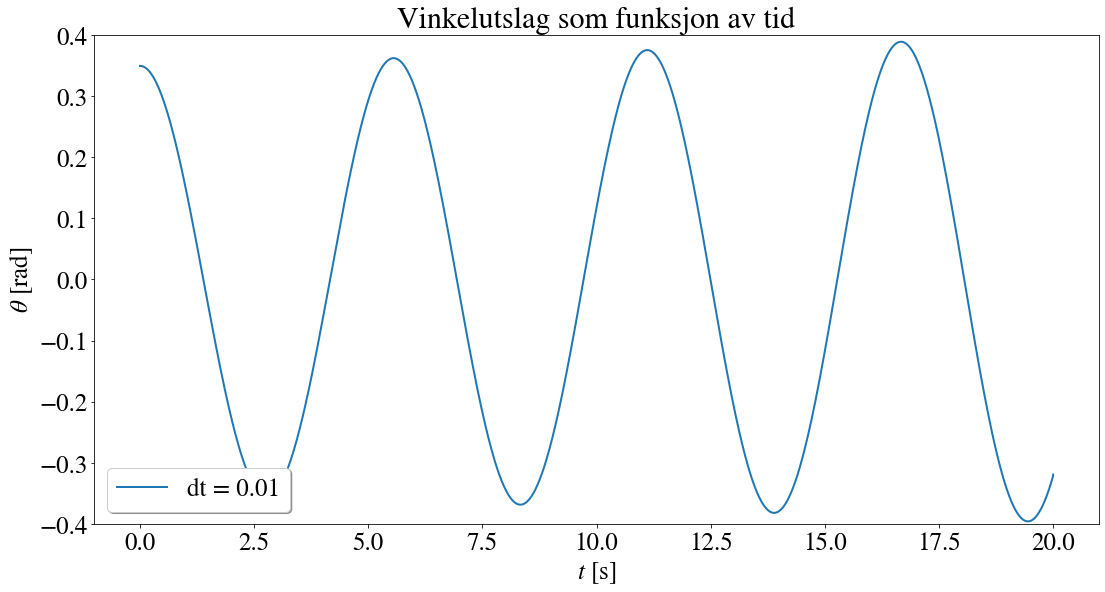

In [35]:
plt.plot(t_num, theta_num, label = "dt = 0.01")
plt.title("Vinkelutslag som funksjon av tid")
plt.xlabel('$t$ [s]')           
plt.ylabel(r'$\theta$ [rad]')   
plt.ylim(-0.4,0.4)        
plt.legend(loc=3, shadow = True)
plt.show()

## Small angle approximation
...

In [36]:
def f(t, w):
    const = (A_s*sigma * g * h)/I_c
    return np.array([w[1], -const*np.sin(w[0])])

def f_small_angle(t, w):
    const = (A_s*sigma * g * h)/I_c
    return np.array([w[1], -const*w[0]])

In [37]:
theta_0 = np.radians(10)
omega_0 = 0
w_0 = np.array([theta_0, omega_0])

t_0 = 0
t_end = 20

h_step = 0.01

t_num, w_num = solve_ODE(f, t_0, t_end, w_0, h_step,euler_step)
t_num_small_angle_approx, w_num_small_angle_approx = solve_ODE(f_small_angle, t_0, t_end, w_0, h_step,euler_step)


theta_num = w_num[:,0]
omega_num = w_num[:,1]
theta_num_small_angle_approx = w_num_small_angle_approx[:,0]
omega_num_small_angle_approx = w_num_small_angle_approx[:,1]

diff = theta_num_small_angle_approx - theta_num

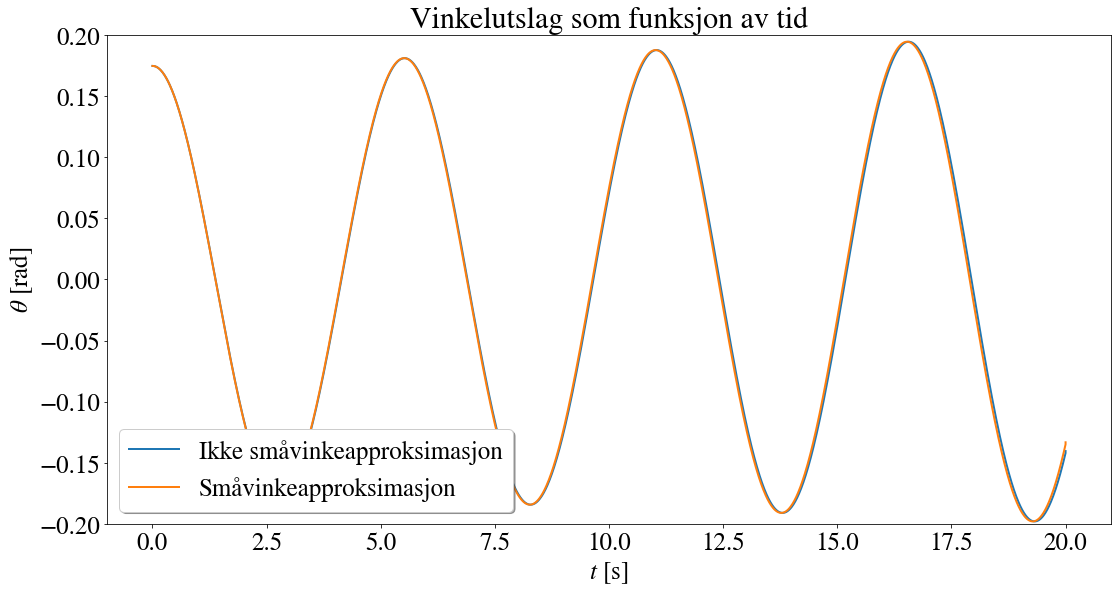

In [38]:
plt.plot(t_num, theta_num, label = "Ikke småvinkeapproksimasjon")
plt.plot(t_num_small_angle_approx, theta_num_small_angle_approx, label = "Småvinkeapproksimasjon")
#plt.plot(t_num, diff, label = "Differanse")
plt.title("Vinkelutslag som funksjon av tid")
plt.xlabel('$t$ [s]')           
plt.ylabel(r'$\theta$ [rad]')   
plt.ylim(-0.2,0.2)        
plt.legend(loc=3, shadow = True)
plt.show()

## 1.3 Runge Kutta metoden

Implementerer fjerde ordens Runge Kutta.


In [39]:
def rk4_step(f, t, w, h):
    '''
    Tar inn en vektor-funksjon på formen f(t, _w_) = _y'_ = _y_ + _g(x)_, med nåværende tid (t) og 
    tilstand (w), og regner ut ett Runge Kutta steg.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t: float, nåvernde tid
        w: s-array, som beskriver systemet
    Ut:
        t_new: neste tidssteg (t+h)
        w_new: systemet etter ett beregnet tidssteg    
    '''
    k_1 = f(t, w)
    k_2 = f(t + 0.5*h, w + h*k_1*0.5)
    k_3 = f(t + 0.5*h, w + h*k_2*0.5)
    k_4 = f(t + 1.0*h, w + h*k_3)

    w_new = w + h*(1/6) * (k_1 + 2*k_2 + 2*k_3 + k_4)
    t_new = t + h

    return t_new, w_new




In [40]:
def f(t, w):
    const = (A_s*sigma * g * h)/I_c
    return np.array([w[1], -const*np.sin(w[0])])

In [41]:
# Sjekker Runge-Kutta

theta_0 = np.radians(20)
omega_0 = 0
w_0 = np.array([theta_0, omega_0])

t_0 = 0
t_end = 20

h_step = 0.01

t_num_rk4, w_num_rk4 = solve_ODE(f, t_0, t_end, w_0, h_step, rk4_step)

theta_num_rk4 = w_num_rk4[:,0]
omega_num_rk = w_num_rk4[:,1]

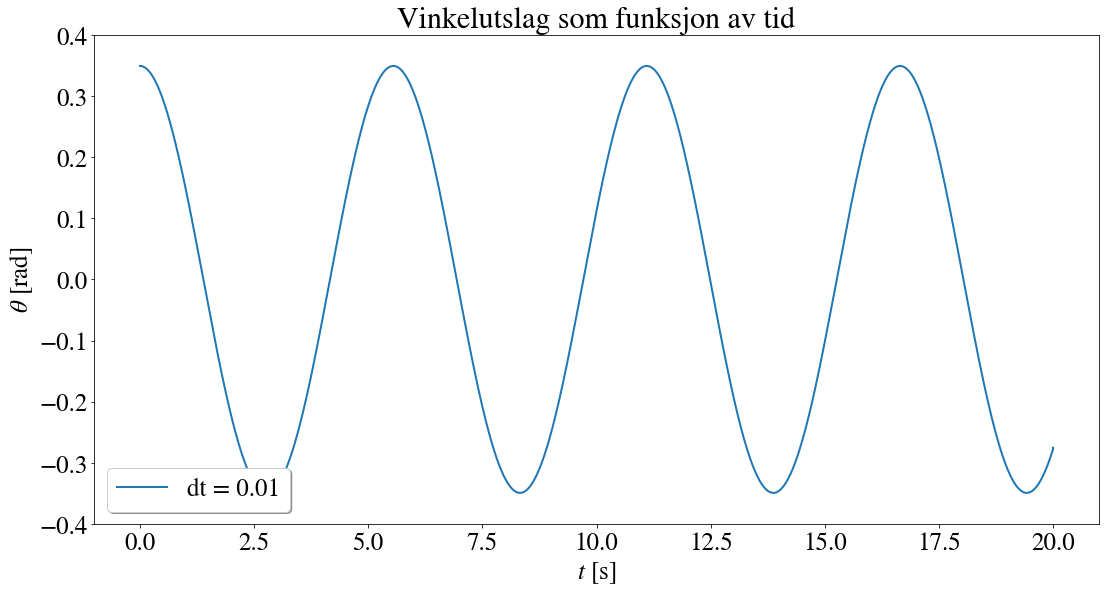

In [42]:
plt.plot(t_num_rk4, theta_num_rk4, label = "dt = 0.01")
plt.title("Vinkelutslag som funksjon av tid")
plt.xlabel('$t$ [s]')           
plt.ylabel(r'$\theta$ [rad]')   
plt.ylim(-0.4,0.4)        
plt.legend(loc=3, shadow = True)
plt.show()

## 1h)
...


In [43]:
def f_analytic(t):
    return 0.01*np.cos(np.sqrt((m*g*h)/I_c)*t)


# To be used in numerical solutions
def f_small_angle(t, w):
    const = (A_s*sigma * g * h)/I_c
    return np.array([w[1], -const*w[0]])
def f_not_small_angle(t, w):
    const = (A_s*sigma * g * h)/I_c
    return np.array([w[1], -const*  np.sin(w[0])])

In [44]:
theta_0 = np.radians(0.01)
omega_0 = 0
w_0 = np.array([theta_0, omega_0])

t_0 = 0
t_end = 20

f_analytic_t_20 = f_analytic(20)

# Antar det er snakk om h som steglengde
h_steps = np.linspace(0.01, 0.8, 1000)

theta_t20_arr_euler = np.array([])
theta_t20_arr_rk4 = np.array([])


for i in range(len(h_steps)):
   result_euler = solve_ODE(f_small_angle, t_0, t_end, w_0, h_steps[i], euler_step)
   result_rk4 = solve_ODE(f_small_angle, t_0, t_end, w_0, h_steps[i], rk4_step)
   theta_t20_arr_euler =np.append(theta_t20_arr_euler, result_euler[1][:,0][-1])
   theta_t20_arr_rk4 = np.append(theta_t20_arr_rk4 ,result_rk4[1][:,0][-1])


difference_euler = theta_t20_arr_euler-f_analytic_t_20
difference_rk4 = theta_t20_arr_rk4-f_analytic_t_20



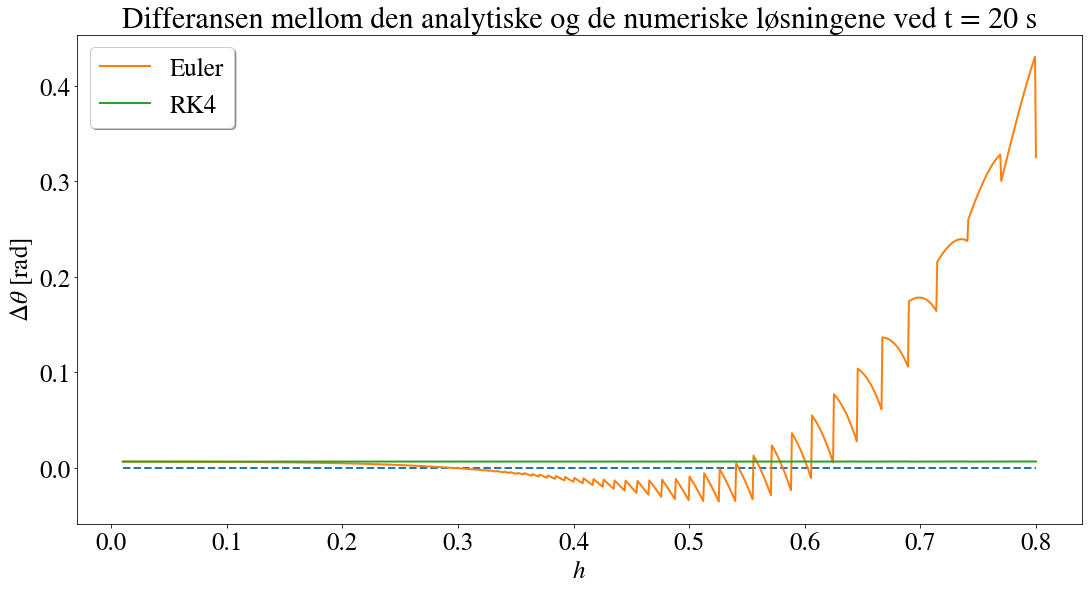

In [45]:
#plt.yscale("log")
plt.plot(h_steps, np.zeros(len(h_steps)),linestyle='--') # Stiplet linje i 0
plt.plot(h_steps, difference_euler, label = "Euler")
plt.plot(h_steps, difference_rk4, label = "RK4")
print()

plt.title("Differansen mellom den analytiske og de numeriske løsningene ved t = 20 s")
plt.xlabel('$h$')           
plt.ylabel(r'$\Delta\theta$ [rad]')   
#plt.ylim(-0.2,0.2)        
plt.legend(loc=2, shadow = True)
plt.show()
# print(f_analytic_t_20)
# x_axis = np.linspace(0,20,len(theta_t20_arr_rk4))
# plt.plot(x_axis,theta_t20_arr_euler)
# plt.show()

In [46]:
#plt.yscale("log")
#plt.plot(h_steps, np.zeros(len(h_steps)),linestyle='--') # Stiplet linje i 0
#plt.plot(h_steps, difference_euler, label = "Euler")
#plt.plot(h_steps, difference_rk4, label = "RK4")
#print()

#plt.title("Differansen mellom den analytiske og de numeriske løsningene ved t = 20 s")
#plt.xlabel('$h$')           
#plt.ylabel(r'$\Delta\theta$ [rad]')   
#plt.ylim(-0.2,0.2)        
#plt.legend(loc=2, shadow = True)
#plt.show()
# print(f_analytic_t_20)
# x_axis = np.linspace(0,20,len(theta_t20_arr_rk4))
# plt.plot(x_axis,theta_t20_arr_euler)
# plt.show()

In [ ]:
'''Denne koden animerer bevegelsen til båtet, gitt at dere sender inn arrays som inneholder tidsverdier t,
skipets helningsvinkel theta, x- og y-koordinatet til skipets massesenter. Disse arraysene brukes i funksjonen
definert nederst "animate_deck_movement". Den grønne sirkelen viser posisjonen til skipets massesenter
Man kan sende inn optional argumenter, disse står beskrevet i funksjonen. For eksempel kan man sende inn et array
som inneholder lastens posisjon relativt metasenteret. Lasten vil da animeres som en rød sirkel.
'''




# M = metasenteret = midt paa dekk
# C = skipets tyngdepunkt


# R = 10  # skipets radius (m)
# h = 4 * R / (3 * np.pi)  # avstand M - C

def init_anim():
    """ Initialises the animation.
    """

    global ax, boat, deck, last, CM, venstre_gjerde, høyre_gjerde, textbox_theory
    boat, = plt.plot([], [],
                    color="k", linewidth=1)
    deck, = plt.plot([], [], color="k", linewidth=1)
    sea_surface, = plt.plot([-R*10, R* 10], [0, 0], color='blue', linewidth=2)  # The surface
    last, = plt.plot([], [], color="r", marker="o", markersize=10)
    CM, = plt.plot([], [], color="g", marker="o", markersize=10)
    venstre_gjerde, = plt.plot([], [], color="k", marker="|", markersize=25)
    høyre_gjerde, = plt.plot([], [], color="k", marker="|", markersize=25)
    ax.set_xlim([-R*1.3, R* 1.3])
    ax.set_ylim([-R*1.1, R* 1.1])
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_aspect("equal")
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    textbox_theory = ax.text(0.775, 0.95, '', transform=ax.transAxes, fontsize=12,
                             verticalalignment='top', bbox=props)

    return ax, boat, deck, last, CM,venstre_gjerde,høyre_gjerde, textbox_theory


def animate(M, theta, t, x_C, y_C, s_L, gjerde=False):
    global ax, boat, deck, last, CM, venstre_gjerde, høyre_gjerde, textbox_theory
    ax.set_xlim([-R * 1.1 + np.amin(x_C), R * 1.1 + np.amax(x_C)])
    ax.set_ylim([-R*1.1, R* 1.1])
    angle_values = np.linspace(0, np.pi, 100)
    metasenter_x = x_C[M] - h * np.sin(theta[M])
    metasenter_y = y_C[M] + h * np.cos(theta[M])
    xs = R * np.cos(angle_values + np.pi + theta[M]) + metasenter_x
    ys = R * np.sin(angle_values + np.pi + theta[M]) + metasenter_y
    boat.set_data(xs, ys)
    deck.set_data([xs[0], xs[-1]], [ys[0], ys[-1]])
    if s_L[M] !=-42:
        last.set_data(metasenter_x + s_L[M] * np.cos(theta[M]),
                      metasenter_y + s_L[M] * np.sin(theta[M]))
    CM.set_data(x_C[M], y_C[M])
    if gjerde:
        venstre_gjerde.set_data([metasenter_x - R * np.cos(theta[M])], [metasenter_y - R * np.sin(theta[M])])
        høyre_gjerde.set_data([metasenter_x + R * np.cos(theta[M])], [metasenter_y + R * np.sin(theta[M])])
    theta_string= r'$\theta = %.2f$' % (theta[M] * 180 / np.pi) + r"$\degree$"
    time_string = '$t =  %.2f$' % (t[M])
    textbox_theory.set_text(
        theta_string + '\n' + time_string)

    M += 1
    return ax, boat, deck, last, CM, venstre_gjerde, høyre_gjerde, textbox_theory


def animate_deck_movement(t, theta, x_C, y_C, s_L=[], gjerde=False, stepsize=0.01, vis_akse_verdier=False):
    """

    :param t: Array som inneholder tidsverdiene man har beregnet \vec{w} for systemet
    :param theta: Array som inneholder utslagsvinkelen til skipet
    :param x_C: Array som inneholder massesenterets x-koordinat
    :param y_C: Array som inneholder massesenterets y-koordinat
    :param s_L: Optional array som inneholder lastens posisjon relativt massesenteret
    :param gjerde: Optional Boolean som forteller om vi skal tegne inn gjerder på skipet
    :param stepsize: Hvor lang tid som skal gå mellom hver frame
    :param vis_akse_verdier: Hvis akse-verdier vises går animasjonen litt mer hakkete, men man kan se tallverdier
    :return: Animasjon som viser dynamikken til skipet
    """
    global fig, ax
    fig, ax = plt.subplots()
    dt = t[1] - t[0]
    skips = max(int(stepsize / dt), 1)
    theta_anim = theta[::skips]
    t_anim = t[::skips]
    x_C_anim = x_C[::skips]
    y_C_anim = y_C[::skips]
    if len(s_L) == 0:
        s_L_anim = -42 * np.ones(len(theta_anim))
    else:
        s_L_anim = s_L[::skips]
    h_anim = animation.FuncAnimation(fig, animate, init_func=init_anim, frames=len(t_anim) - 1, interval=1,
                                     blit=not vis_akse_verdier,
                                     fargs=(theta_anim, t_anim, x_C_anim, y_C_anim, s_L_anim, gjerde))
    plt.show()


## 2b

In [47]:
# w[0] = theta
# w[1] = omega
# w[2] = x
# w[3] = y
# w[4] = v_x
# w[5] = v_y


def f(t, w):  
    '''
    Funksjon som brukes til å regne ut de nye verdiene til w-arrayet.
    Inn:
        t: float, tid
        w: s-array, beskriver diverse av systemets fysiske egenskaper
    Ut:
        w-arrayet med oppdaterte verdier
    
    '''
    
    
    delta_y_c_current = w[3] - y_C_0   
    gamma_current = 2*np.arccos(np.cos(beta/2) - (4/(3*np.pi))*(1-np.cos(w[0])) + delta_y_c_current/R)

    A = water_area(gamma_current)
    return np.array([w[1], -((F_B(A) * h)/I_c)*np.sin(w[0]), w[4], w[5], 0, (F_G(m) + F_B(A))/m])

In [48]:
theta_0 = np.radians(20)
omega_0 = 0
x_C_0 = 0
v_x_0 = 0
v_y_0 = 0

w_0 = np.array([theta_0, omega_0, x_C_0, y_C_0, v_x_0, v_y_0])

t_0 = 0
t_end = 20

h_step = 0.01

t_num_rk4, w_num_rk4 = solve_ODE(f, t_0, t_end, w_0, h_step, rk4_step)

#theta_num_rk4 = w_num_rk4[:,0]
y_num_rk4 = w_num_rk4[:,3]
omega_num_rk = w_num_rk4[:,1]

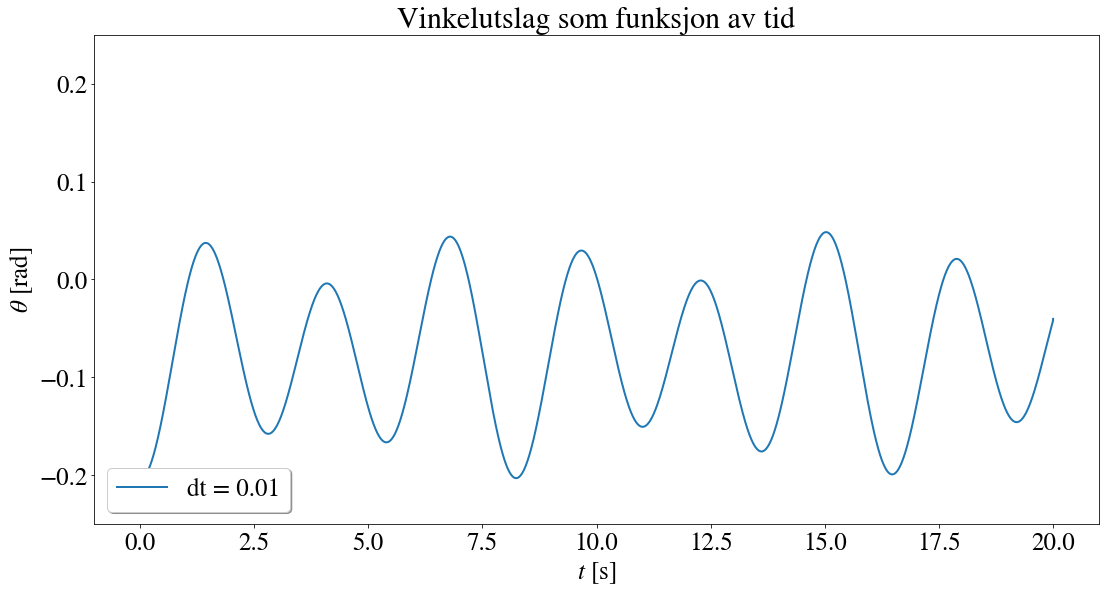

In [49]:
plt.plot(t_num_rk4, y_num_rk4, label = "dt = 0.01")
plt.title("Vinkelutslag som funksjon av tid")
plt.xlabel('$t$ [s]')           
plt.ylabel(r'$\theta$ [rad]')   
plt.ylim(-0.25,0.25)        
plt.legend(loc=3, shadow = True)
plt.show()

# X.0 Conclusion

Lorem Ipsum...